K-Nearest Neighbors

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, roc_curve,accuracy_score,precision_score,recall_score
,make_scorer,f1_score,auc,precision_recall_curve)
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV


In [17]:
# Load dataset
data = pd.read_csv('data.csv')
# Display the first few rows of the dataset
print(data.columns)

Index(['Unnamed: 0', 'location', 'country', 'gender', 'age', 'vis_wuhan',
       'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4',
       'symptom5', 'symptom6', 'diff_sym_hos', 'result'],
      dtype='object')


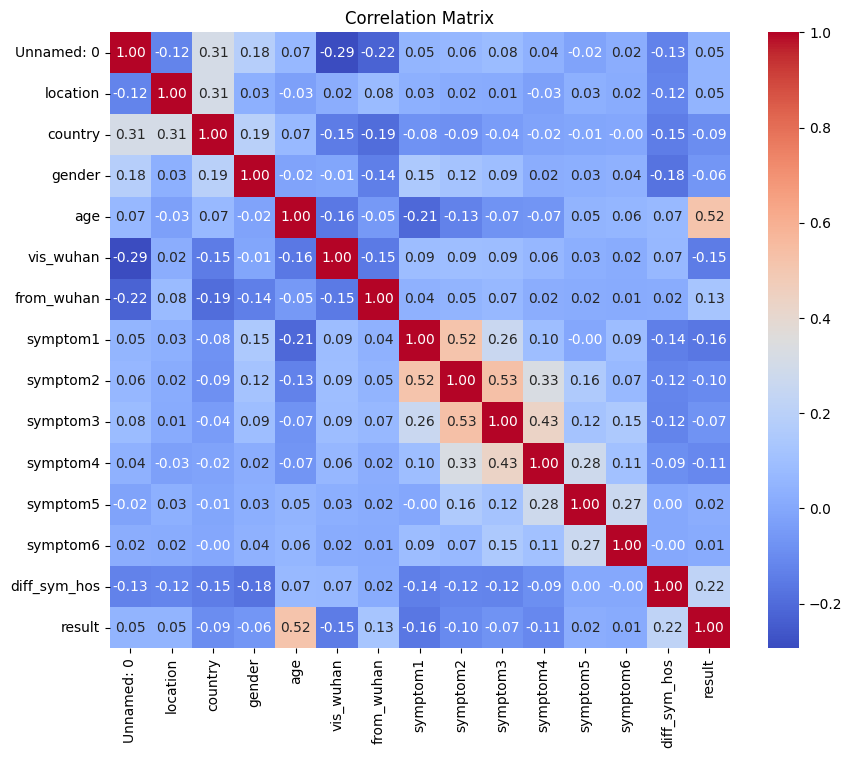

Correlation with target (result):
result          1.000000
age             0.515127
diff_sym_hos    0.219116
from_wuhan      0.128314
Unnamed: 0      0.046838
location        0.046240
symptom5        0.020676
symptom6        0.012882
gender         -0.061441
symptom3       -0.074982
country        -0.094443
symptom2       -0.103270
symptom4       -0.108723
vis_wuhan      -0.151122
symptom1       -0.163039
Name: result, dtype: float64


In [18]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Get the correlation of each feature with the target ('Result')
target_correlation = correlation_matrix['result'].sort_values(ascending=False)

# Print the correlation of features with the target
print("Correlation with target (result):")
print(target_correlation)


In [19]:
# Feature-target split, drop useless features (have low values of correlation)
X = data.drop(['result', 'Unnamed: 0','location','symptom5','symptom6'], axis=1) 
y = data['result']

# Split into training (70%), validation (15%), and testing (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Total number of samples
total_samples = len(data)

# Calculate sizes and percentages
train_size = len(X_train) / total_samples * 100
val_size = len(X_val) / total_samples * 100
test_size = len(X_test) / total_samples * 100

# Print the data sizes and percentages
print(f"Training set size: {len(X_train)} samples ({train_size:.2f}%)")
print(f"Validation set size: {len(X_val)} samples ({val_size:.2f}%)")
print(f"Testing set size: {len(X_test)} samples ({test_size:.2f}%)")


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)




Training set size: 604 samples (69.99%)
Validation set size: 129 samples (14.95%)
Testing set size: 130 samples (15.06%)


In [20]:
best_k = 0
best_recall = 0

# Create StratifiedKFold with random_state for consistency
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a custom scorer using recall
recall_scorer = make_scorer(recall_score)

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    # Use the recall scorer for cross-validation
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring=recall_scorer)  # 5-fold cross-validation
    mean_recall = cv_scores.mean()
    #print(f"k={k}, Cross-Validation Recall: {mean_recall}")
    if (mean_recall > best_recall) & (k!=1): #to avoid overfitting
        best_k = k
        best_recall = mean_recall

print(f"Optimal number of neighbors (k) for maximum recall: {best_k}")



Optimal number of neighbors (k) for maximum recall: 3


In [21]:
# 5. Train the KNN classifier with the optimal k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Confusion Matrix:
[[113   0]
 [  0  16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       113
           1       0.83      0.62      0.71        16

    accuracy                           0.94       129
   macro avg       0.89      0.80      0.84       129
weighted avg       0.93      0.94      0.93       129


ROC-AUC Score: 0.9834


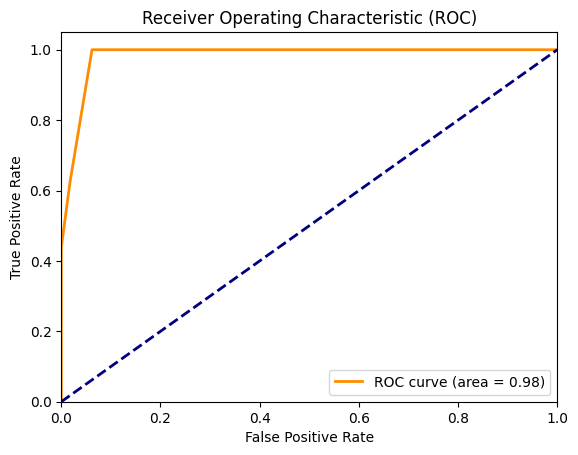

In [50]:
knn.fit(X_val, y_val)
# 6. Predict on the test set
y_pred_val = knn.predict(X_val)
y_pred_proba_val = knn.predict_proba(X_val)[:, 1]  # Probability for the positive class
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val))

# Classification Report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))

# ROC-AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba_val)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_val)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [22]:
# 6. Predict on the test set
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:, 1]  # Probability for the positive class

Confusion Matrix:
[[111   3]
 [  3  13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       114
           1       0.81      0.81      0.81        16

    accuracy                           0.95       130
   macro avg       0.89      0.89      0.89       130
weighted avg       0.95      0.95      0.95       130


ROC-AUC Score: 0.9490


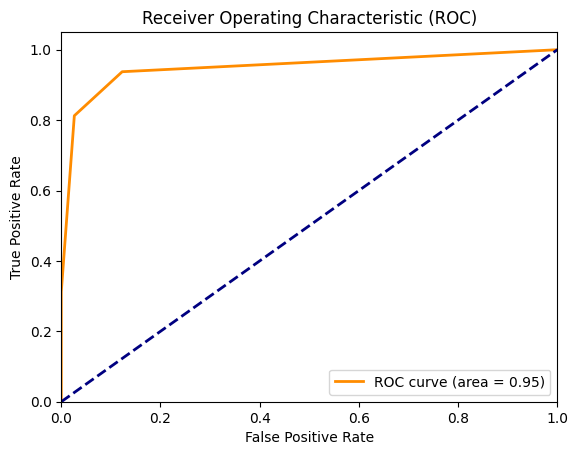

In [23]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report (precision, recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Logistic Regression 

In [24]:
# Handle class imbalance using SMOTE
RANDOM_STATE=42
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=RANDOM_STATE)

In [25]:
# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 5000],
    'class_weight': ['balanced', None],
}

# Perform GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(
    log_reg,
    param_grid,
    scoring='f1',  # Optimize for F1-score
    refit='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    verbose=1
)

# Fit GridSearchCV to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Extract the best model
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}


In [26]:
# Evaluate on validation data
y_val_proba = best_model.predict_proba(X_val)[:, 1]  # Probabilities for ROC and threshold tuning

# Tune Threshold for Optimal Precision-Recall Balance
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
optimal_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls))  # Maximize F1-Score
optimal_threshold = thresholds[optimal_idx]

# Apply the new threshold
y_val_pred_threshold = (y_val_proba >= optimal_threshold).astype(int)



Validation Set Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       113
           1       0.70      0.88      0.78        16

    accuracy                           0.94       129
   macro avg       0.84      0.91      0.87       129
weighted avg       0.95      0.94      0.94       129

Confusion Matrix:
[[107   6]
 [  2  14]]
ROC-AUC Score: 0.9635
Optimal Threshold: 0.7144


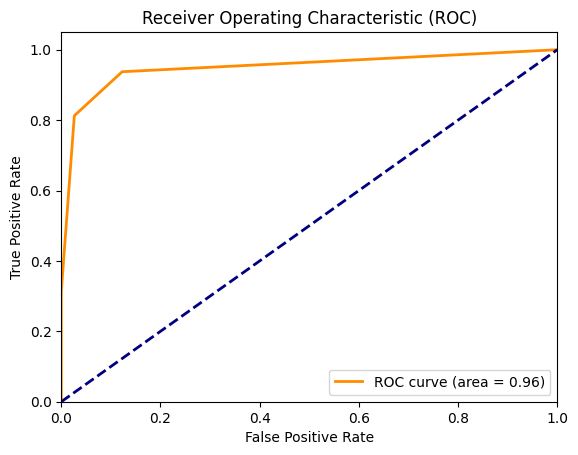

In [28]:
# Metrics
print("\nValidation Set Metrics:")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_threshold))

roc_auc = roc_auc_score(y_val, y_val_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Test Set Metrics:
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       114
           1       0.78      0.88      0.82        16

    accuracy                           0.95       130
   macro avg       0.88      0.92      0.90       130
weighted avg       0.96      0.95      0.95       130

Confusion Matrix:
[[110   4]
 [  2  14]]
ROC-AUC Score: 0.9545
Optimal Threshold: 0.6223


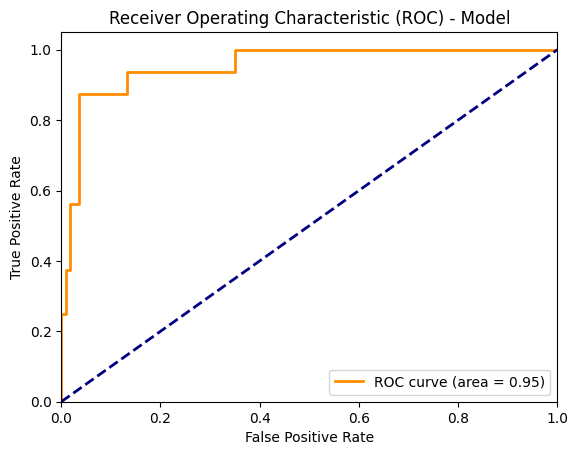

In [31]:
# Evaluate on test data
y_test_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC and threshold tuning

# Tune Threshold for Optimal Precision-Recall Balance
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba)
optimal_idx = np.argmax(2 * (precisions * recalls) / (precisions + recalls))  # Maximize F1-Score
optimal_threshold = thresholds[optimal_idx]

# Apply the new threshold
y_test_pred_threshold = (y_test_proba >= optimal_threshold).astype(int)

# Metrics for Test Set
print("\nTest Set Metrics:")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_threshold))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_threshold))

roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC Score: {roc_auc_test:.4f}")

print(f"Optimal Threshold: {optimal_threshold:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Model')
plt.legend(loc="lower right")
plt.show()


Naive Bayes


Naïve Bayes - Test Set Metrics (Enhanced):
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       113
           1       0.80      0.75      0.77        16

    accuracy                           0.95       129
   macro avg       0.88      0.86      0.87       129
weighted avg       0.94      0.95      0.94       129

Confusion Matrix:
[[110   3]
 [  4  12]]
ROC-AUC Score: 0.9466
Optimal Threshold: 0.9999


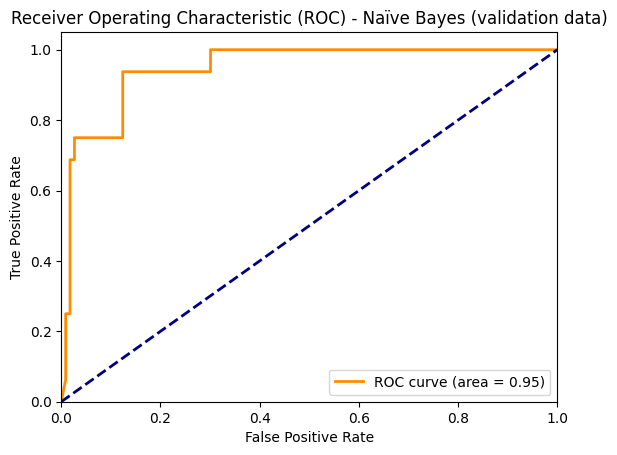

In [40]:
RANDOM_STATE=42
# Naïve Bayes with isotonic calibration
validated_nb=GaussianNB(var_smoothing=1e-9)
#naive_bayes = GaussianNB(var_smoothing=1e-9)
#validated_nb = CalibratedClassifierCV(naive_bayes, method='isotonic')

# Fit model
validated_nb.fit(X_val, y_val)

# Predict probabilities
y_val_proba = validated_nb.predict_proba(X_val)[:, 1]

# Optimize threshold for F1-Score
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_nb = thresholds[optimal_idx]

# Apply threshold
y_val_pred_threshold_nb = (y_val_proba >= optimal_threshold_nb).astype(int)

# Metrics
print("\nNaïve Bayes - Test Set Metrics (Enhanced):")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_threshold_nb))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_threshold_nb))

roc_auc_test_nb = roc_auc_score(y_val, y_val_proba)
print(f"ROC-AUC Score: {roc_auc_test_nb:.4f}")
print(f"Optimal Threshold: {optimal_threshold_nb:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Naïve Bayes (validation data)')
plt.legend(loc="lower right")
plt.show()


Naïve Bayes - Test Set Metrics (Enhanced):
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       114
           1       0.59      0.62      0.61        16

    accuracy                           0.90       130
   macro avg       0.77      0.78      0.77       130
weighted avg       0.90      0.90      0.90       130

Confusion Matrix:
[[107   7]
 [  6  10]]
ROC-AUC Score: 0.8766
Optimal Threshold: 0.9772


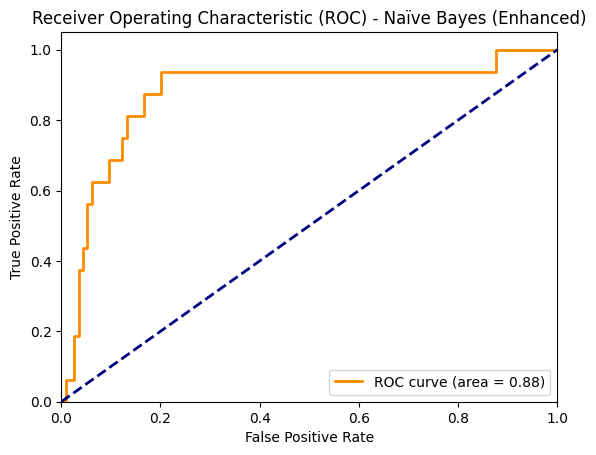

In [49]:
from imblearn.combine import SMOTETomek

# Scaling
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Naïve Bayes with isotonic calibration
naive_bayes_test=GaussianNB(var_smoothing=1e-9)
#naive_bayes = GaussianNB(var_smoothing=1e-9)
#naive_bayes_test
# = CalibratedClassifierCV(naive_bayes, method='isotonic')

# Fit model
naive_bayes_test.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
y_test_proba_nb = naive_bayes_test.predict_proba(X_test)[:, 1]

# Optimize threshold for F1-Score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba_nb)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_nb = thresholds[optimal_idx]

# Apply threshold
y_test_pred_threshold_nb = (y_test_proba_nb >= optimal_threshold_nb).astype(int)

# Metrics
print("\nNaïve Bayes - Test Set Metrics (Enhanced):")
print("Classification Report:")
print(classification_report(y_test, y_test_pred_threshold_nb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_threshold_nb))

roc_auc_test_nb = roc_auc_score(y_test, y_test_proba_nb)
print(f"ROC-AUC Score: {roc_auc_test_nb:.4f}")
print(f"Optimal Threshold: {optimal_threshold_nb:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba_nb)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Naïve Bayes (Enhanced)')
plt.legend(loc="lower right")
plt.show()
